In [5]:
# import necessary packages
import pandas as pd 
import datetime
import numpy as np 
import yfinance as yf
import os, contextlib
from transformers import pipeline
from transformers import pipeline
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# import all necessary modules from keras
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.layers import LSTM
from keras.layers import Dropout
import re

from sklearn.preprocessing import MinMaxScaler

In [27]:
# Donwnload NASDAQ Historical Data
offset = 0
limit = False
period = 'max' # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
 
data = pd.read_csv("http://www.nasdaqtrader.com/dynamic/SymDir/nasdaqtraded.txt", sep='|')
data_clean = data[data['Test Issue'] == 'N']
symbols = data_clean['NASDAQ Symbol'].tolist()
print('total number of symbols traded = {}'.format(len(symbols)))
!mkdir hist
limit = limit if limit else len(symbols)
end = min(offset + limit, len(symbols))
is_valid = [False] * len(symbols)
# force silencing of verbose API
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        for i in range(offset, end):
            s = symbols[i]
            try:
                data = yf.download(s, period=period)
            except:
                continue
            if len(data.index) == 0:
                continue
        
            is_valid[i] = True
            data.to_csv('hist/{}.csv'.format(s))

print('Total number of valid symbols downloaded = {}'.format(sum(is_valid)))

valid_data = data_clean[is_valid]
valid_data.to_csv('symbols_valid_meta.csv', index=False)

!mkdir stocks
!mkdir etfs

etfs = valid_data[valid_data['ETF'] == 'Y']['NASDAQ Symbol'].tolist()
stocks = valid_data[valid_data['ETF'] == 'N']['NASDAQ Symbol'].tolist()

import shutil
from os.path import isfile, join

def move_symbols(symbols, dest):
    for s in symbols:
        filename = '{}.csv'.format(s)
        shutil.move(join('hist', filename), join(dest, filename))
        
move_symbols(etfs, "etfs")
move_symbols(stocks, "stocks")

! rmdir hist

total number of symbols traded = 11299


## Tesla with Public Opinion Feature

In [2]:
# In this chunk, we perform sentiment analysis
# load the tweets from 3 csv files
tweet = pd.read_csv("/Users/alan/Desktop/DL/FinalProject/tweets/Tweet.csv")
company_tweet = pd.read_csv("/Users/alan/Desktop/DL/FinalProject/tweets/Company_Tweet.csv")
company = pd.read_csv("/Users/alan/Desktop/DL/FinalProject/tweets/Company.csv")
tweet["post_date"] = pd.to_datetime(tweet['post_date'], unit='s')
tweet=tweet.merge(company_tweet,left_on="tweet_id",right_on="tweet_id")
tsla = tweet.loc[tweet["ticker_symbol"]=="TSLA",:].reset_index()

# create SentimentIntensityAnalyzer object and perform the sentiment analysis
sia = SentimentIntensityAnalyzer()
tsla['sentiment_scores'] = tsla['body'].apply(lambda tweet: sia.polarity_scores(tweet))
tsla['compound']  = tsla['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])
tsla['sentiment'] = tsla['compound'].apply(lambda c: 'positive' if c >=0.05 else ('neutral' if c > -0.05 and c < 0.05 else 'negative'))
tsla["post_date"] = tsla["post_date"].dt.date

# compute the mean of compounded intraday data
tsla_sentiment_daily = tsla.groupby("post_date").agg(score = ("compound","mean"))

Epoch 1/25
8/8 [==============================] - 6s 550ms/step - loss: 0.1401 - val_loss: 0.0440
Epoch 2/25
8/8 [==============================] - 4s 509ms/step - loss: 0.0221 - val_loss: 0.0160
Epoch 3/25
8/8 [==============================] - 4s 511ms/step - loss: 0.0092 - val_loss: 0.0066
Epoch 4/25
8/8 [==============================] - 4s 480ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 5/25
8/8 [==============================] - 4s 486ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 6/25
8/8 [==============================] - 4s 482ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 7/25
8/8 [==============================] - 4s 490ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 8/25
8/8 [==============================] - 4s 485ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 9/25
8/8 [==============================] - 4s 486ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 10/25
8/8 [==============================] - 4s 489ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 11/25
8/8 [==

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_1832/1189839459.py:85: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_1832/1189839459.py:86: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


<Figure size 640x480 with 0 Axes>

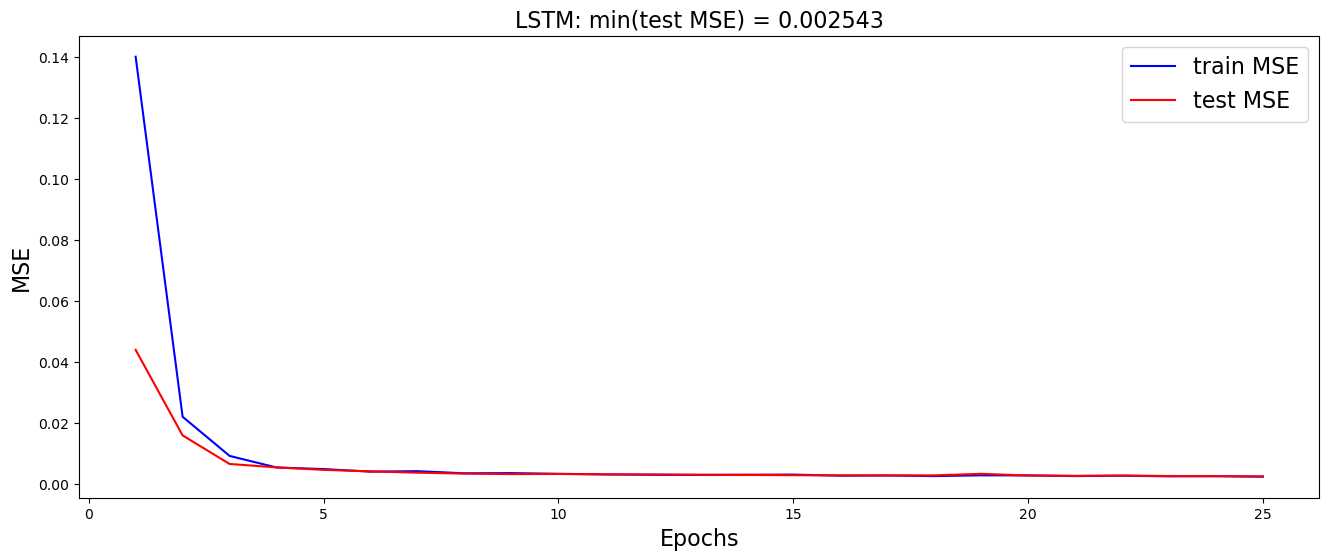

5/8 [=================>............] - ETA: 0s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_1832/1189839459.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


8/8 [==============================] - 0s 32ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_1832/1189839459.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_1832/1189839459.py:106: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


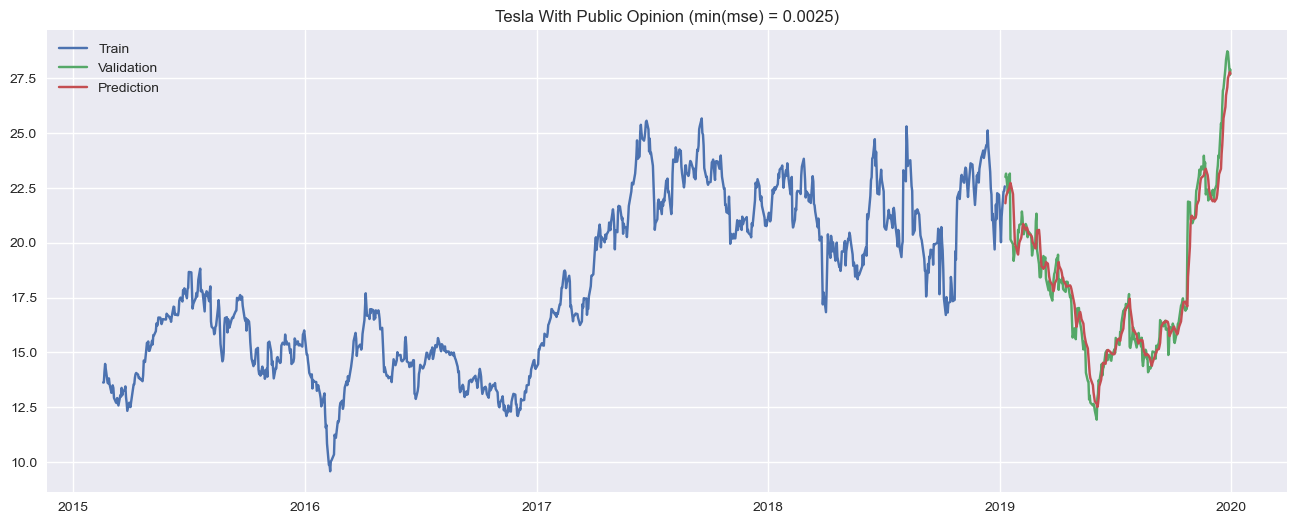

In [4]:
# load the tesla stock price data
tsla_price_daily = pd.read_csv("/Users/alan/Desktop/DL/FinalProject/stocks/TSLA.csv",parse_dates=["Date"],index_col="Date")
start_date = "2015-01-01"
end_date = "2019-12-31"
tsla_price_daily = tsla_price_daily.loc[start_date:end_date]
tsla_price_daily = tsla_price_daily.merge(tsla_sentiment_daily,left_index=True,right_index=True)

# prepare the tensor needed for the LSTM training process
n_timesteps = 30

features_set = []
labels = []
for i in range(n_timesteps, tsla_price_daily.shape[0]):
    features_set.append(tsla_price_daily.iloc[(i-n_timesteps):i,:])
    labels.append(tsla_price_daily.iloc[i,3])
    
features_set, labels = np.array(features_set), np.array(labels)

# split the train & test dataset
n = features_set.shape[0]
n_train = int(n * 0.80)
n_test = n - n_train
#print("n_train = ",str(n_train))
#print("n_test = ",str(n_test))

features_set_train, features_set_test =  features_set[0:n_train,:,:], features_set[n_train:n,:,:]
labels_train, labels_test =  labels[0:n_train], labels[n_train:n]

# data preprocessing and do the scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape to 2D
features_set_train_2D = features_set_train.reshape(-1, features_set_train.shape[-1])
features_set_test_2D = features_set_test.reshape(-1, features_set_test.shape[-1])

# Reshape labels to be 2D
labels_train_2D = labels_train.reshape(-1, 1)
labels_test_2D = labels_test.reshape(-1, 1)

# Fit the two scalers
scaler_X.fit(features_set_train_2D)
scaler_y.fit(labels_train_2D)

# Do the transformation
features_set_train_scaled_2D = scaler_X.transform(features_set_train_2D)
features_set_test_scaled_2D = scaler_X.transform(features_set_test_2D)

features_set_train_scaled = features_set_train_scaled_2D.reshape(features_set_train.shape)
features_set_test_scaled = features_set_test_scaled_2D.reshape(features_set_test.shape)

# Transform the labels and reshape them back
labels_train_scaled_2D = scaler_y.transform(labels_train_2D)
labels_test_scaled_2D = scaler_y.transform(labels_test_2D)

labels_train_scaled = labels_train_scaled_2D.reshape(-1)
labels_test_scaled = labels_test_scaled_2D.reshape(-1)

# Set the model
n_features = 7

model_lstm = models.Sequential()
model_lstm.add(LSTM(512, return_sequences=False, activation='tanh', input_shape=(n_timesteps,n_features)))
model_lstm.add(Dropout(0.4))
model_lstm.add(layers.Dense(100, activation='linear')) 
model_lstm.add(layers.Dense(1, activation='relu')) 

# train the model
nepochs = 25
model_lstm.compile(optimizer='adam',
              loss='mse')
history = model_lstm.fit(features_set_train_scaled, labels_train_scaled,
          epochs=nepochs,
          batch_size=128,
          validation_data=(features_set_test_scaled, labels_test_scaled))

# define all the plot functions
plt.clf()   # clear figure
history_lstm = history.history
train_mse = history_lstm['loss']
test_mse = history_lstm['val_loss']
min_test_mse = min(test_mse)

plt.figure(figsize=(16,6))
plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")

#plt.ylim((0, 0.0001))
plt.title('LSTM: min(test MSE) = ' + str(round(min(test_mse),6)),fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.legend(loc = 'upper right',fontsize=16)
# plt.ylim(0,0.0015)
plt.show()

# do the plot of the prediction
train = tsla_price_daily.iloc[30:(30+len(labels_train)),:]
y_hat_train = model_lstm.predict(features_set_train_scaled)
y_hat_train = scaler_y.inverse_transform(y_hat_train)
train["prediction"] = y_hat_train

valid = tsla_price_daily.iloc[(30+len(labels_train)):,:]
y_hat_valid = model_lstm.predict(features_set_test_scaled)
y_hat_valid = scaler_y.inverse_transform(y_hat_valid)
valid["prediction"] = y_hat_valid
plt.style.use('seaborn')
plt.figure(figsize=(16,6))
plt.plot(train["Close"],label = "Train")
plt.plot(valid[["Close","prediction"]],label = ["Validation","Prediction"])
plt.title("Tesla With Public Opinion (min(mse) = {:.4f})".format(min_test_mse))
plt.legend()
plt.show()

### High-Tech:  
Apple Inc. (AAPL); Microsoft Corporation (MSFT); Amazon.com, Inc. (AMZN); Tesla Inc. (TSLA) 

### Traditional Industry
PepsiCo, Inc. (PEP); Starbucks Corporation (SBUX); The Kraft Heinz Company (KHC); Sysco Corporation (SYY)

### High-Tech EFTs:  
Invesco QQQ ETF (QQQ); Technology Select Sector SPDR Fund (XLK); First Trust DJ Internet Index Fund (FDN); ARK Innovation ETF (ARKK)

### Traditional Industry EFTs:
Consumer Staples Select Sector SPDR Fund (XLP); Vanguard Consumer Discretionary ETF (VCR); Vanguard Utilities ETF (VPU); Vanguard Industrials ETF (VIS)

Epoch 1/15
67/67 [==============================] - 35s 511ms/step - loss: 0.0030 - val_loss: 1.2663
Epoch 2/15
67/67 [==============================] - 34s 509ms/step - loss: 5.0637e-04 - val_loss: 1.0932
Epoch 3/15
67/67 [==============================] - 35s 523ms/step - loss: 5.2235e-04 - val_loss: 0.9410
Epoch 4/15
67/67 [==============================] - 35s 522ms/step - loss: 5.8807e-04 - val_loss: 0.9003
Epoch 5/15
67/67 [==============================] - 34s 511ms/step - loss: 5.0016e-04 - val_loss: 0.8977
Epoch 6/15
67/67 [==============================] - 34s 513ms/step - loss: 5.6292e-04 - val_loss: 0.6938
Epoch 7/15
67/67 [==============================] - 34s 508ms/step - loss: 4.6518e-04 - val_loss: 0.5841
Epoch 8/15
67/67 [==============================] - 34s 508ms/step - loss: 4.9950e-04 - val_loss: 0.7447
Epoch 9/15
67/67 [==============================] - 34s 505ms/step - loss: 4.6950e-04 - val_loss: 0.7589
Epoch 10/15
67/67 [==============================] - 34s 50

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/67 [=>............................] - ETA: 2s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


67/67 [==============================] - 2s 33ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
59/59 [==============================] - 33s 538ms/step - loss: 0.0080 - val_loss: 0.6640
Epoch 2/15
59/59 [==============================] - 31s 518ms/step - loss: 0.0016 - val_loss: 0.6380
Epoch 3/15
59/59 [==============================] - 31s 519ms/step - loss: 0.0015 - val_loss: 0.4793
Epoch 4/15
59/59 [==============================] - 31s 527ms/step - loss: 0.0015 - val_loss: 0.3672
Epoch 5/15
59/59 [==============================] - 31s 519ms/step - loss: 0.0014 - val_loss: 0.3441
Epoch 6/15
59/59 [==============================] - 31s 519ms/step - loss: 0.0015 - val_loss: 0.3038
Epoch 7/15
59/59 [==============================] - 31s 519ms/step - loss: 0.0013 - val_loss: 0.2618
Epoch 8/15
59/59 [==============================] - 31s 520ms/step - loss: 0.0013 - val_loss: 0.2552
Epoch 9/15
59/59 [==============================] - 31s 519ms/step - loss: 0.0012 - val_loss: 0.2140
Epoch 10/15
59/59 [==============================] - 31s 520ms/step - loss: 0.0013 - val_lo

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/59 [=>............................] - ETA: 1s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


59/59 [==============================] - 2s 33ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
42/42 [==============================] - 23s 521ms/step - loss: 0.0034 - val_loss: 0.0085
Epoch 2/15
42/42 [==============================] - 22s 513ms/step - loss: 0.0010 - val_loss: 0.0061
Epoch 3/15
42/42 [==============================] - 22s 513ms/step - loss: 5.2965e-04 - val_loss: 0.0050
Epoch 4/15
42/42 [==============================] - 22s 513ms/step - loss: 6.3548e-04 - val_loss: 0.0265
Epoch 5/15
42/42 [==============================] - 21s 512ms/step - loss: 5.4459e-04 - val_loss: 0.0093
Epoch 6/15
42/42 [==============================] - 21s 511ms/step - loss: 4.3957e-04 - val_loss: 0.0123
Epoch 7/15
42/42 [==============================] - 22s 514ms/step - loss: 5.0373e-04 - val_loss: 0.0034
Epoch 8/15
42/42 [==============================] - 21s 509ms/step - loss: 4.3175e-04 - val_loss: 0.0067
Epoch 9/15
42/42 [==============================] - 22s 519ms/step - loss: 6.5575e-04 - val_loss: 0.0028
Epoch 10/15
42/42 [==============================] - 23s 542ms/

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/42 [==>...........................] - ETA: 1s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


42/42 [==============================] - 1s 32ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
21/21 [==============================] - 13s 561ms/step - loss: 0.0038 - val_loss: 0.0084
Epoch 2/15
21/21 [==============================] - 11s 530ms/step - loss: 5.5240e-04 - val_loss: 0.0098
Epoch 3/15
21/21 [==============================] - 11s 509ms/step - loss: 4.2710e-04 - val_loss: 0.0065
Epoch 4/15
21/21 [==============================] - 11s 510ms/step - loss: 3.8024e-04 - val_loss: 0.0047
Epoch 5/15
21/21 [==============================] - 11s 509ms/step - loss: 3.8662e-04 - val_loss: 0.0077
Epoch 6/15
21/21 [==============================] - 11s 508ms/step - loss: 4.1025e-04 - val_loss: 0.0035
Epoch 7/15
21/21 [==============================] - 11s 509ms/step - loss: 3.7011e-04 - val_loss: 0.0039
Epoch 8/15
21/21 [==============================] - 11s 511ms/step - loss: 3.8332e-04 - val_loss: 0.0035
Epoch 9/15
21/21 [==============================] - 11s 507ms/step - loss: 3.9880e-04 - val_loss: 0.0051
Epoch 10/15
21/21 [==============================] - 11s 51

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/21 [======>.......................] - ETA: 0s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


21/21 [==============================] - 1s 32ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
81/81 [==============================] - 43s 522ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 2/15
81/81 [==============================] - 42s 519ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 3/15
81/81 [==============================] - 42s 517ms/step - loss: 0.0014 - val_loss: 0.0072
Epoch 4/15
81/81 [==============================] - 43s 526ms/step - loss: 0.0014 - val_loss: 0.0060
Epoch 5/15
81/81 [==============================] - 42s 523ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 6/15
81/81 [==============================] - 43s 531ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 7/15
81/81 [==============================] - 42s 517ms/step - loss: 0.0012 - val_loss: 0.0061
Epoch 8/15
81/81 [==============================] - 42s 518ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/15
81/81 [==============================] - 42s 518ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 10/15
81/81 [==============================] - 42s 521ms/step - loss: 0.0011 - val_lo

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 3/81 [>.............................] - ETA: 2s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


81/81 [==============================] - 3s 35ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
49/49 [==============================] - 28s 550ms/step - loss: 0.0076 - val_loss: 0.0014
Epoch 2/15
49/49 [==============================] - 26s 527ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 3/15
49/49 [==============================] - 25s 520ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/15
49/49 [==============================] - 26s 523ms/step - loss: 9.8934e-04 - val_loss: 0.0041
Epoch 5/15
49/49 [==============================] - 26s 530ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 6/15
49/49 [==============================] - 26s 541ms/step - loss: 9.5187e-04 - val_loss: 0.0012
Epoch 7/15
49/49 [==============================] - 25s 521ms/step - loss: 9.5266e-04 - val_loss: 0.0012
Epoch 8/15
49/49 [==============================] - 25s 519ms/step - loss: 8.9314e-04 - val_loss: 0.0011
Epoch 9/15
49/49 [==============================] - 25s 520ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 10/15
49/49 [==============================] - 25s 519ms/step - loss:

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/49 [==>...........................] - ETA: 1s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


49/49 [==============================] - 2s 33ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
13/13 [==============================] - 8s 541ms/step - loss: 0.0532 - val_loss: 5.4350e-04
Epoch 2/15
13/13 [==============================] - 7s 523ms/step - loss: 0.0059 - val_loss: 9.5955e-04
Epoch 3/15
13/13 [==============================] - 7s 518ms/step - loss: 0.0037 - val_loss: 2.4153e-04
Epoch 4/15
13/13 [==============================] - 7s 523ms/step - loss: 0.0031 - val_loss: 1.4892e-04
Epoch 5/15
13/13 [==============================] - 7s 517ms/step - loss: 0.0030 - val_loss: 2.4562e-04
Epoch 6/15
13/13 [==============================] - 7s 516ms/step - loss: 0.0029 - val_loss: 1.1908e-04
Epoch 7/15
13/13 [==============================] - 7s 522ms/step - loss: 0.0027 - val_loss: 1.2439e-04
Epoch 8/15
13/13 [==============================] - 7s 517ms/step - loss: 0.0026 - val_loss: 1.2728e-04
Epoch 9/15
13/13 [==============================] - 7s 522ms/step - loss: 0.0027 - val_loss: 2.0918e-04
Epoch 10/15
13/13 [==============================] - 7s 520ms/st

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


50/50 [==============================] - 2s 33ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


13/13 [==============================] - 1s 32ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
79/79 [==============================] - 42s 523ms/step - loss: 0.0071 - val_loss: 0.0024
Epoch 2/15
79/79 [==============================] - 41s 521ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 3/15
79/79 [==============================] - 41s 518ms/step - loss: 0.0016 - val_loss: 0.0072
Epoch 4/15
79/79 [==============================] - 41s 519ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 5/15
79/79 [==============================] - 41s 519ms/step - loss: 0.0014 - val_loss: 0.0048
Epoch 6/15
79/79 [==============================] - 41s 520ms/step - loss: 0.0014 - val_loss: 0.0054
Epoch 7/15
79/79 [==============================] - 41s 517ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 8/15
79/79 [==============================] - 41s 519ms/step - loss: 0.0013 - val_loss: 0.0067
Epoch 9/15
79/79 [==============================] - 42s 532ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 10/15
79/79 [==============================] - 41s 521ms/step - loss: 0.0012 - val_lo

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/79 [>.............................] - ETA: 2s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


79/79 [==============================] - 3s 33ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
39/39 [==============================] - 21s 505ms/step - loss: 0.0202 - val_loss: 0.0065
Epoch 2/15
39/39 [==============================] - 19s 498ms/step - loss: 0.0014 - val_loss: 0.0137
Epoch 3/15
39/39 [==============================] - 19s 495ms/step - loss: 0.0012 - val_loss: 0.0091
Epoch 4/15
39/39 [==============================] - 19s 496ms/step - loss: 0.0011 - val_loss: 0.0102
Epoch 5/15
39/39 [==============================] - 19s 496ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 6/15
39/39 [==============================] - 19s 497ms/step - loss: 0.0010 - val_loss: 0.0058
Epoch 7/15
39/39 [==============================] - 19s 499ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 8/15
39/39 [==============================] - 19s 496ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 9/15
39/39 [==============================] - 19s 496ms/step - loss: 0.0011 - val_loss: 0.0282
Epoch 10/15
39/39 [==============================] - 19s 497ms/step - loss: 0.0011 - val_lo

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/39 [==>...........................] - ETA: 1s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


39/39 [==============================] - 1s 32ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
39/39 [==============================] - 21s 522ms/step - loss: 0.0138 - val_loss: 0.0270
Epoch 2/15
39/39 [==============================] - 20s 514ms/step - loss: 0.0014 - val_loss: 0.0251
Epoch 3/15
39/39 [==============================] - 20s 516ms/step - loss: 0.0012 - val_loss: 0.0162
Epoch 4/15
39/39 [==============================] - 20s 514ms/step - loss: 0.0013 - val_loss: 0.0139
Epoch 5/15
39/39 [==============================] - 20s 516ms/step - loss: 0.0012 - val_loss: 0.0176
Epoch 6/15
39/39 [==============================] - 20s 515ms/step - loss: 0.0012 - val_loss: 0.0163
Epoch 7/15
39/39 [==============================] - 20s 515ms/step - loss: 0.0011 - val_loss: 0.0159
Epoch 8/15
39/39 [==============================] - 20s 515ms/step - loss: 0.0011 - val_loss: 0.0117
Epoch 9/15
39/39 [==============================] - 20s 515ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 10/15
39/39 [==============================] - 20s 514ms/step - loss: 0.0012 - val_lo

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/39 [==>...........................] - ETA: 1s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


39/39 [==============================] - 1s 32ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:124: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.f

Epoch 1/15
27/27 [==============================] - 15s 526ms/step - loss: 0.0200 - val_loss: 0.0020
Epoch 2/15
27/27 [==============================] - 14s 515ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 3/15
27/27 [==============================] - 14s 514ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 4/15
27/27 [==============================] - 14s 513ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 5/15
27/27 [==============================] - 14s 513ms/step - loss: 0.0016 - val_loss: 0.0065
Epoch 6/15
27/27 [==============================] - 14s 512ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 7/15
27/27 [==============================] - 14s 515ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/15
27/27 [==============================] - 14s 515ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 9/15
27/27 [==============================] - 14s 514ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 10/15
27/27 [==============================] - 14s 513ms/step - loss: 0.0015 - val_lo

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/27 [====>.........................] - ETA: 0s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


27/27 [==============================] - 1s 33ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
14/14 [==============================] - 8s 508ms/step - loss: 0.0261 - val_loss: 0.0018
Epoch 2/15
14/14 [==============================] - 7s 487ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 3/15
14/14 [==============================] - 7s 491ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 4/15
14/14 [==============================] - 7s 485ms/step - loss: 0.0016 - val_loss: 8.3061e-04
Epoch 5/15
14/14 [==============================] - 7s 483ms/step - loss: 0.0014 - val_loss: 5.1325e-04
Epoch 6/15
14/14 [==============================] - 7s 486ms/step - loss: 0.0013 - val_loss: 4.6844e-04
Epoch 7/15
14/14 [==============================] - 7s 511ms/step - loss: 0.0012 - val_loss: 4.6884e-04
Epoch 8/15
14/14 [==============================] - 7s 509ms/step - loss: 0.0013 - val_loss: 3.7850e-04
Epoch 9/15
14/14 [==============================] - 7s 498ms/step - loss: 0.0013 - val_loss: 5.0818e-04
Epoch 10/15
14/14 [==============================] - 7s 502ms/step - loss: 0

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/14 [=========>....................] - ETA: 0s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


14/14 [==============================] - 0s 32ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
39/39 [==============================] - 22s 525ms/step - loss: 0.0281 - val_loss: 0.0011
Epoch 2/15
39/39 [==============================] - 20s 515ms/step - loss: 0.0020 - val_loss: 7.9010e-04
Epoch 3/15
39/39 [==============================] - 20s 516ms/step - loss: 0.0018 - val_loss: 7.7031e-04
Epoch 4/15
39/39 [==============================] - 20s 516ms/step - loss: 0.0016 - val_loss: 9.2497e-04
Epoch 5/15
39/39 [==============================] - 20s 518ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 6/15
39/39 [==============================] - 20s 516ms/step - loss: 0.0020 - val_loss: 0.0070
Epoch 7/15
39/39 [==============================] - 20s 517ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/15
39/39 [==============================] - 20s 517ms/step - loss: 0.0016 - val_loss: 7.6470e-04
Epoch 9/15
39/39 [==============================] - 20s 520ms/step - loss: 0.0016 - val_loss: 6.0046e-04
Epoch 10/15
39/39 [==============================] - 20s 516ms/step - l

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/39 [==>...........................] - ETA: 1s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


39/39 [==============================] - 1s 32ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
31/31 [==============================] - 17s 524ms/step - loss: 0.0133 - val_loss: 0.0109
Epoch 2/15
31/31 [==============================] - 16s 508ms/step - loss: 0.0020 - val_loss: 0.0116
Epoch 3/15
31/31 [==============================] - 16s 515ms/step - loss: 0.0020 - val_loss: 0.0120
Epoch 4/15
31/31 [==============================] - 16s 513ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 5/15
31/31 [==============================] - 16s 514ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 6/15
31/31 [==============================] - 16s 514ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 7/15
31/31 [==============================] - 16s 514ms/step - loss: 0.0017 - val_loss: 0.0067
Epoch 8/15
31/31 [==============================] - 16s 513ms/step - loss: 0.0016 - val_loss: 0.0067
Epoch 9/15
31/31 [==============================] - 16s 515ms/step - loss: 0.0016 - val_loss: 0.0075
Epoch 10/15
31/31 [==============================] - 16s 513ms/step - loss: 0.0015 - val_lo

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/31 [===>..........................] - ETA: 0s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


31/31 [==============================] - 1s 32ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
31/31 [==============================] - 17s 522ms/step - loss: 0.0212 - val_loss: 0.0017
Epoch 2/15
31/31 [==============================] - 16s 513ms/step - loss: 0.0022 - val_loss: 9.1039e-04
Epoch 3/15
31/31 [==============================] - 16s 512ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 4/15
31/31 [==============================] - 16s 513ms/step - loss: 0.0017 - val_loss: 8.8700e-04
Epoch 5/15
31/31 [==============================] - 16s 513ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 6/15
31/31 [==============================] - 16s 513ms/step - loss: 0.0016 - val_loss: 9.0519e-04
Epoch 7/15
31/31 [==============================] - 16s 513ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/15
31/31 [==============================] - 16s 514ms/step - loss: 0.0015 - val_loss: 9.7852e-04
Epoch 9/15
31/31 [==============================] - 16s 513ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 10/15
31/31 [==============================] - 16s 513ms/step - loss:

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/31 [===>..........................] - ETA: 0s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


31/31 [==============================] - 1s 33ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Epoch 1/15
30/30 [==============================] - 16s 506ms/step - loss: 0.0204 - val_loss: 0.0021
Epoch 2/15
30/30 [==============================] - 15s 497ms/step - loss: 0.0030 - val_loss: 9.4812e-04
Epoch 3/15
30/30 [==============================] - 15s 497ms/step - loss: 0.0025 - val_loss: 9.7227e-04
Epoch 4/15
30/30 [==============================] - 15s 497ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 5/15
30/30 [==============================] - 15s 497ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 6/15
30/30 [==============================] - 15s 498ms/step - loss: 0.0022 - val_loss: 9.4616e-04
Epoch 7/15
30/30 [==============================] - 15s 500ms/step - loss: 0.0024 - val_loss: 9.1037e-04
Epoch 8/15
30/30 [==============================] - 15s 497ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 9/15
30/30 [==============================] - 15s 497ms/step - loss: 0.0023 - val_loss: 9.4032e-04
Epoch 10/15
30/30 [==============================] - 15s 497ms/step - l

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")


 5/30 [====>.........................] - ETA: 0s

/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["prediction"] = y_hat_train


30/30 [==============================] - 1s 32ms/step


/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["prediction"] = y_hat_valid
/var/folders/fk/gb6xmqy52c3bv2ysb6pv8gww0000gn/T/ipykernel_39283/2714370216.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Figure size 800x550 with 0 Axes>

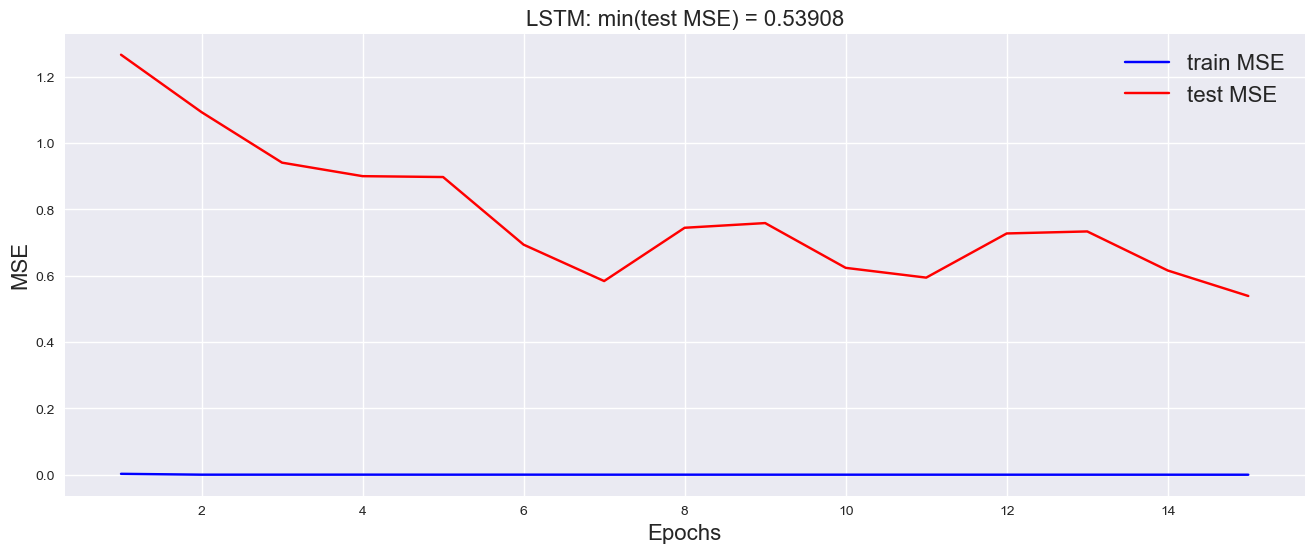

<Figure size 1600x600 with 0 Axes>

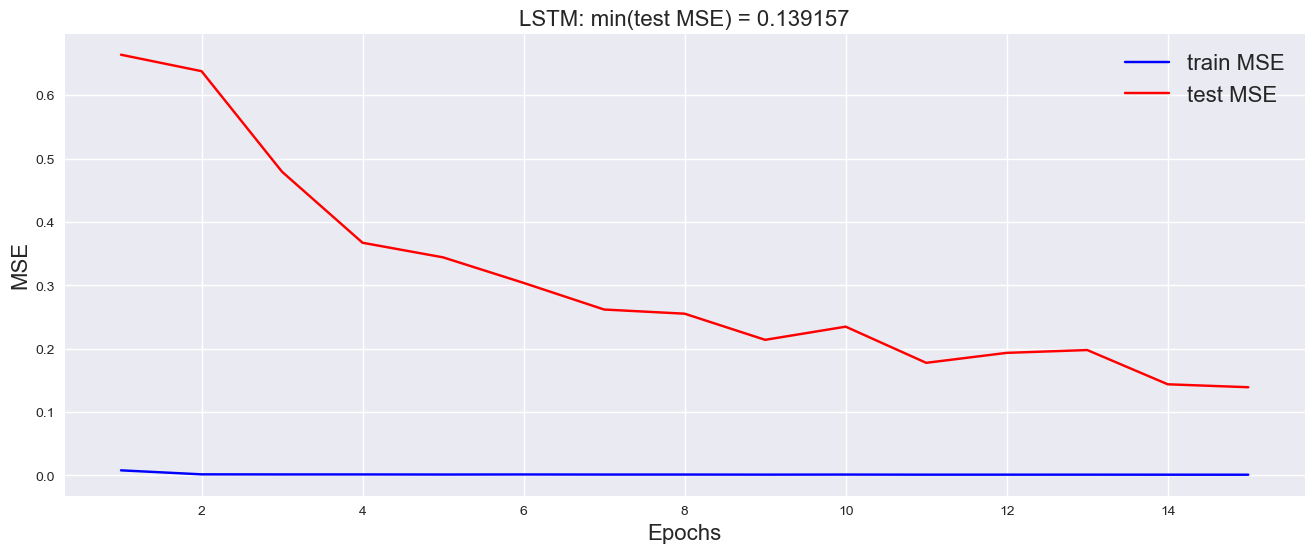

<Figure size 1600x600 with 0 Axes>

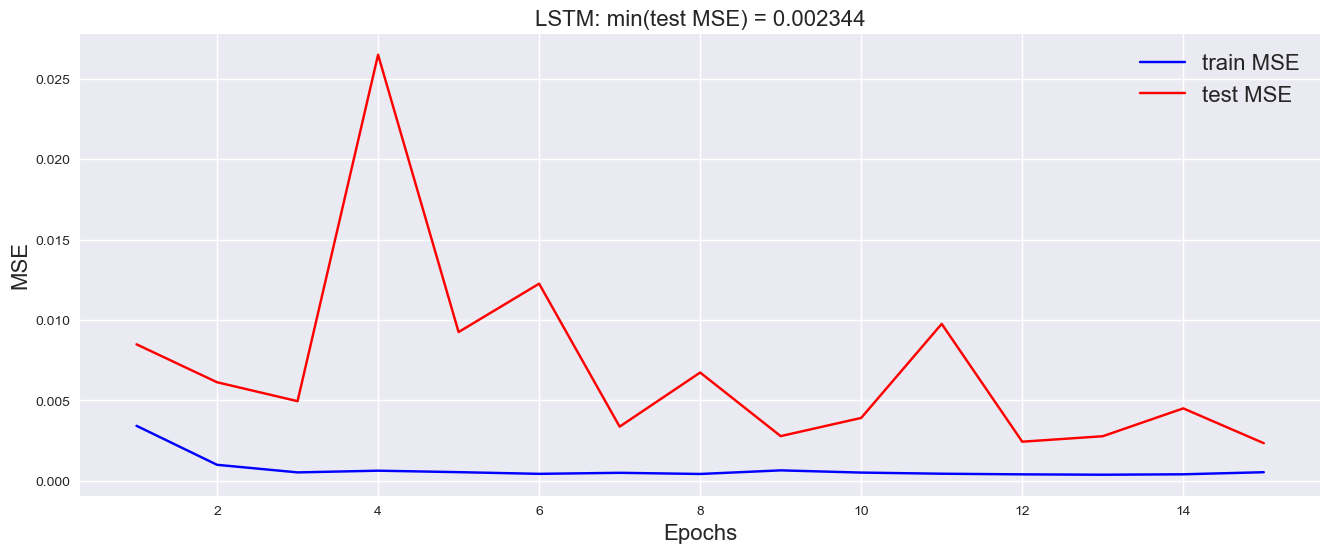

<Figure size 1600x600 with 0 Axes>

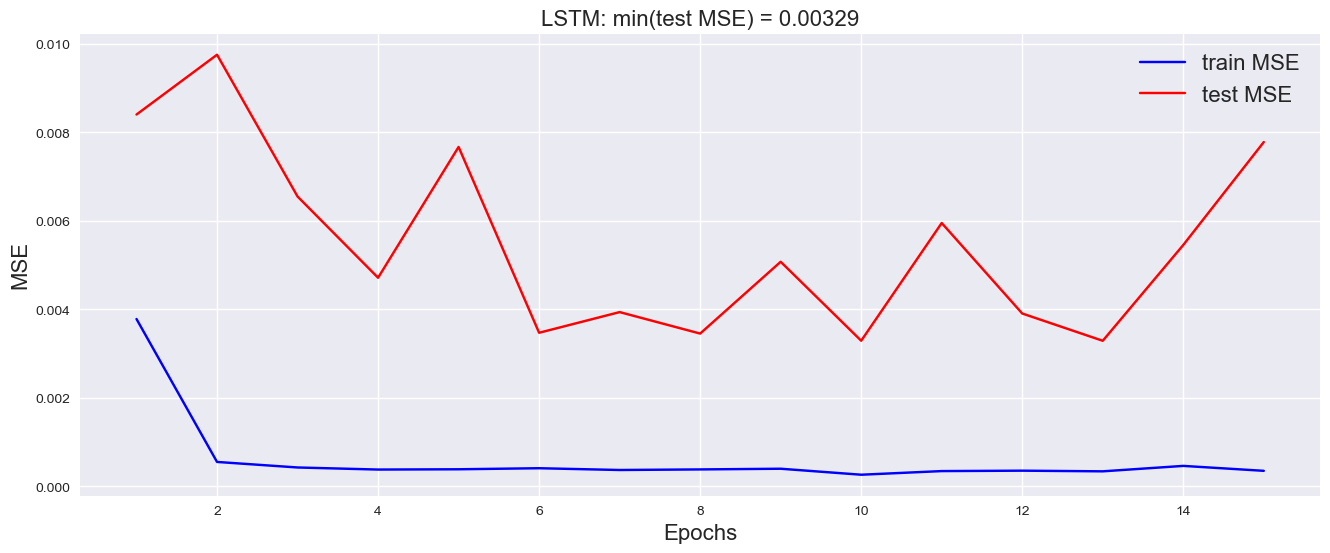

<Figure size 1600x600 with 0 Axes>

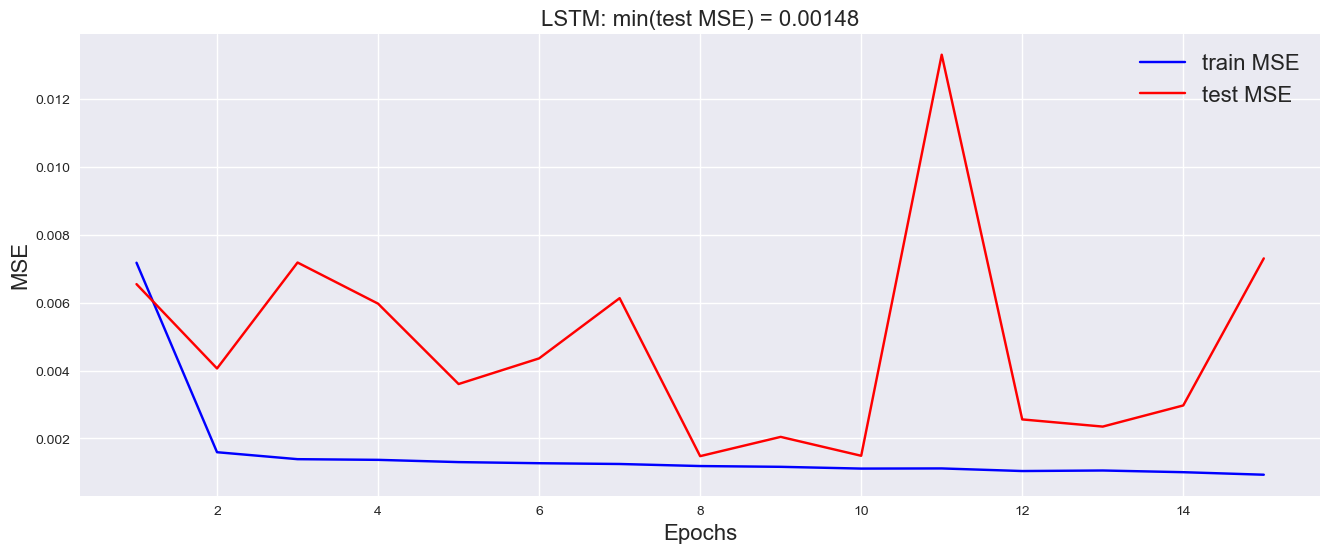

<Figure size 1600x600 with 0 Axes>

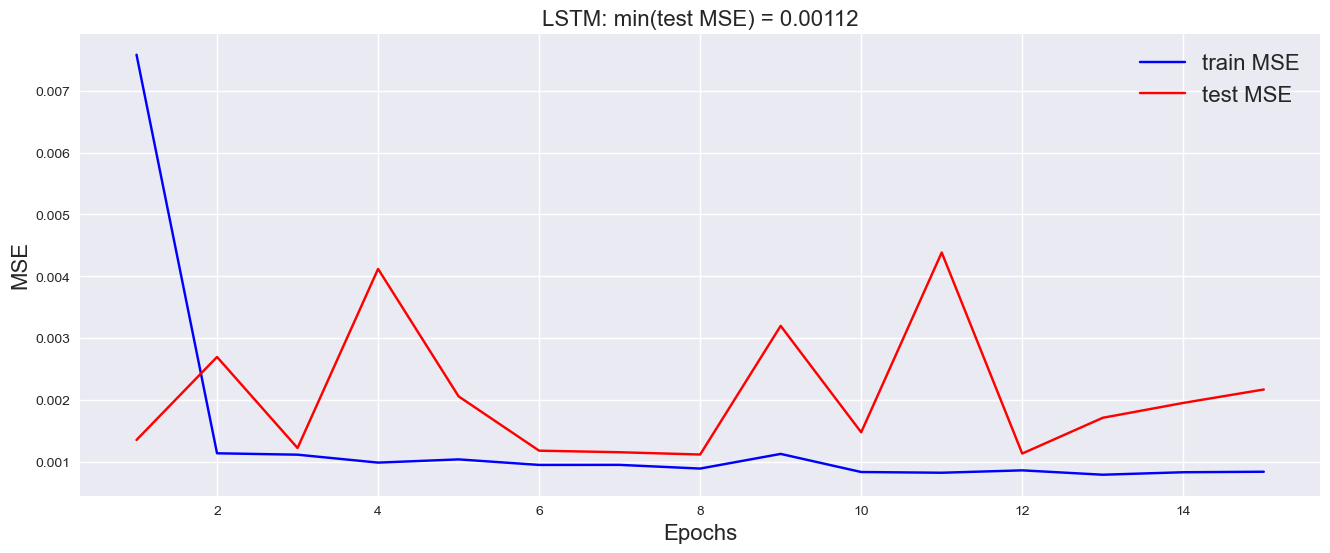

<Figure size 1600x600 with 0 Axes>

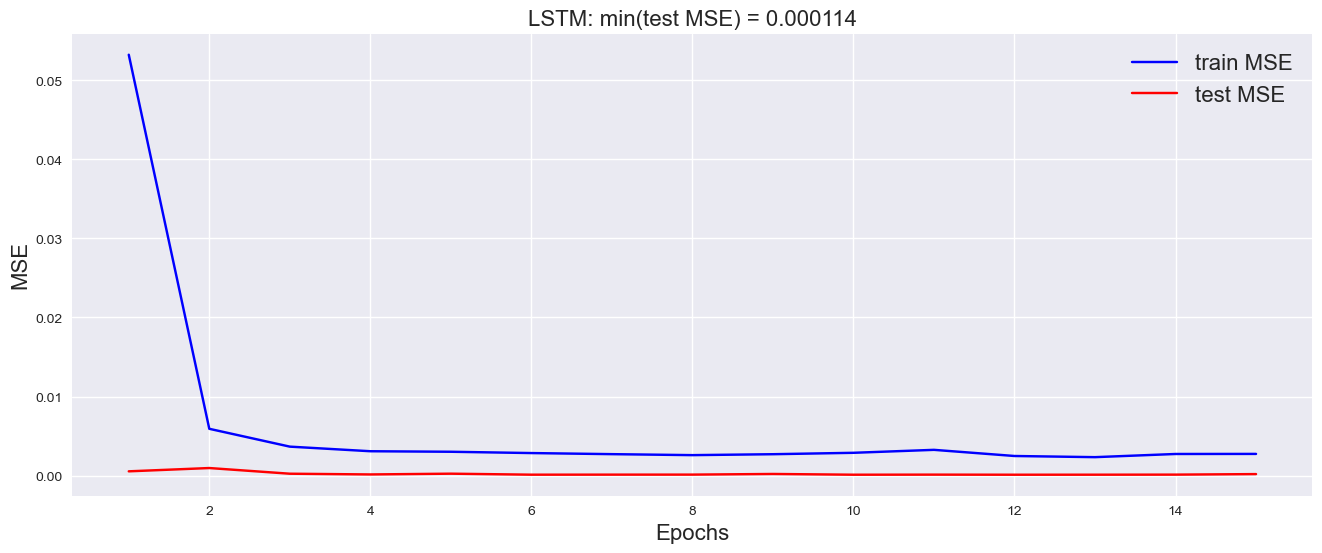

<Figure size 1600x600 with 0 Axes>

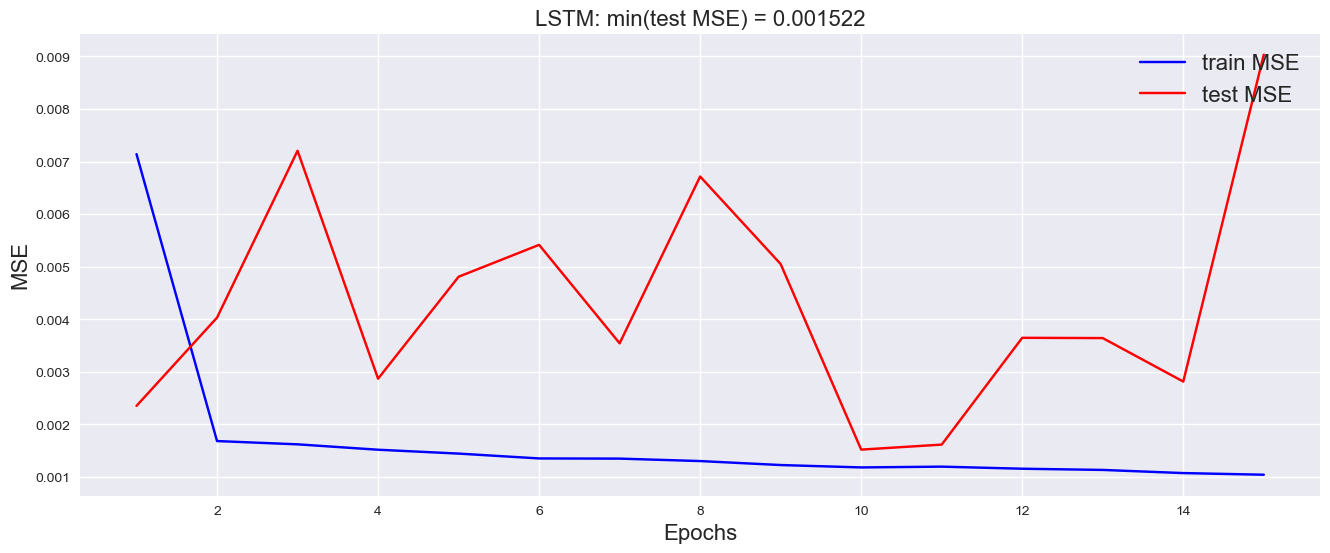

<Figure size 1600x600 with 0 Axes>

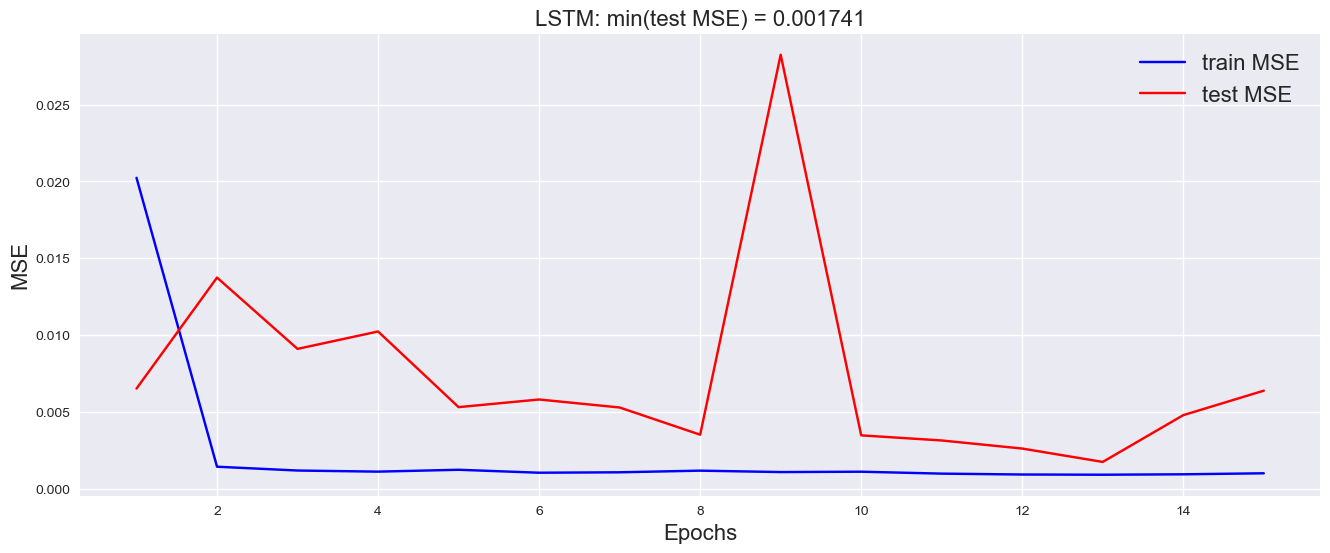

<Figure size 1600x600 with 0 Axes>

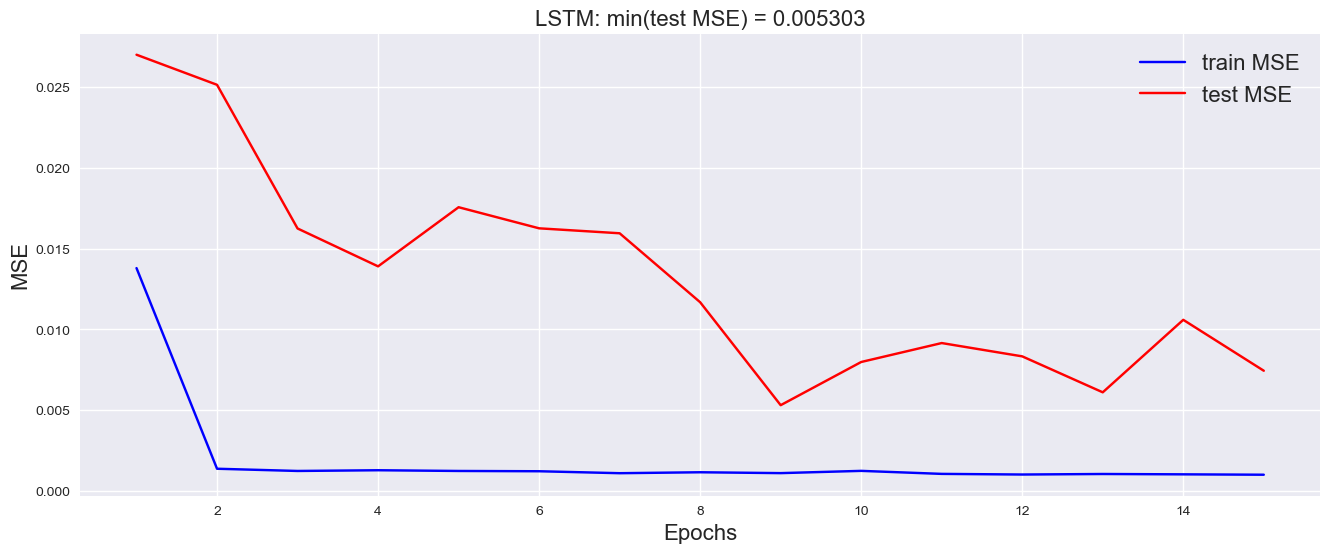

<Figure size 1600x600 with 0 Axes>

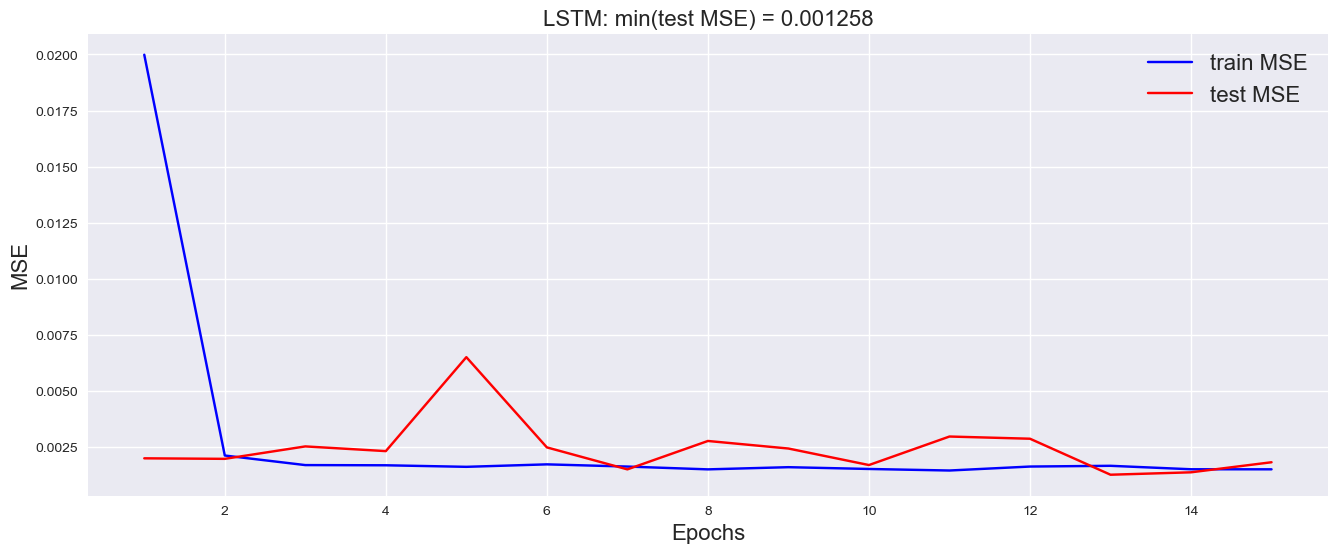

<Figure size 1600x600 with 0 Axes>

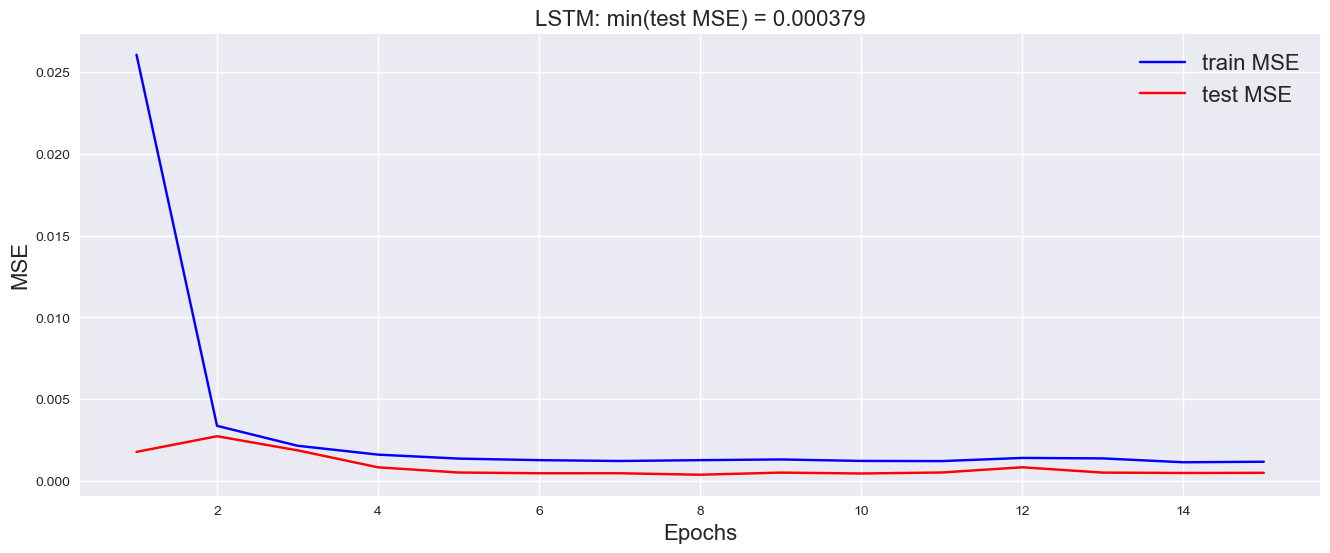

<Figure size 1600x600 with 0 Axes>

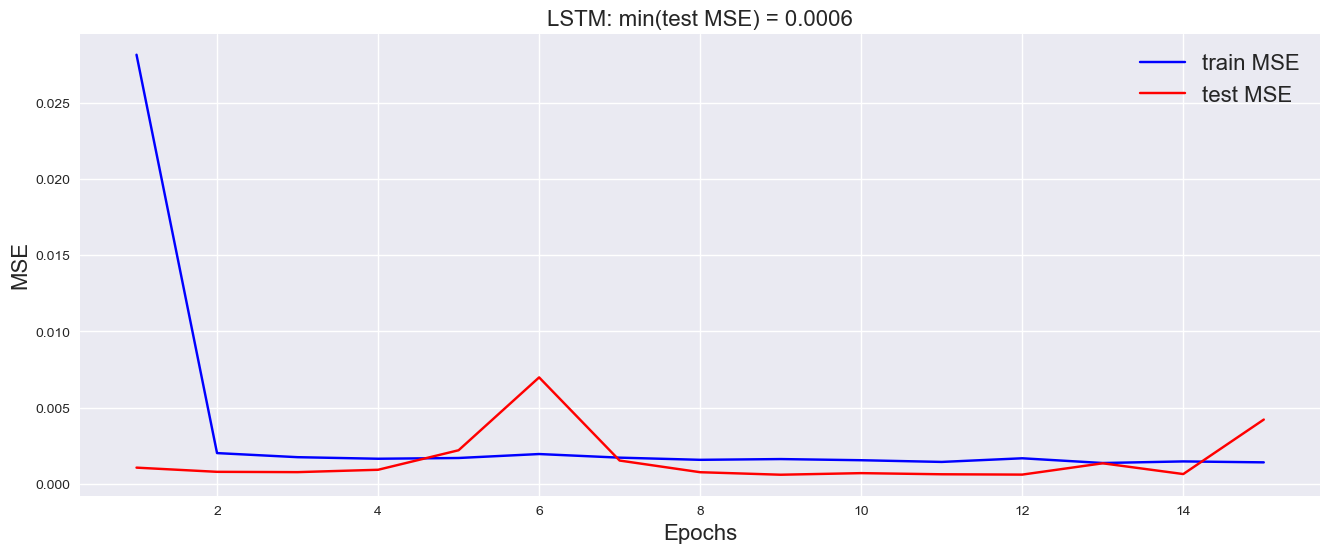

<Figure size 1600x600 with 0 Axes>

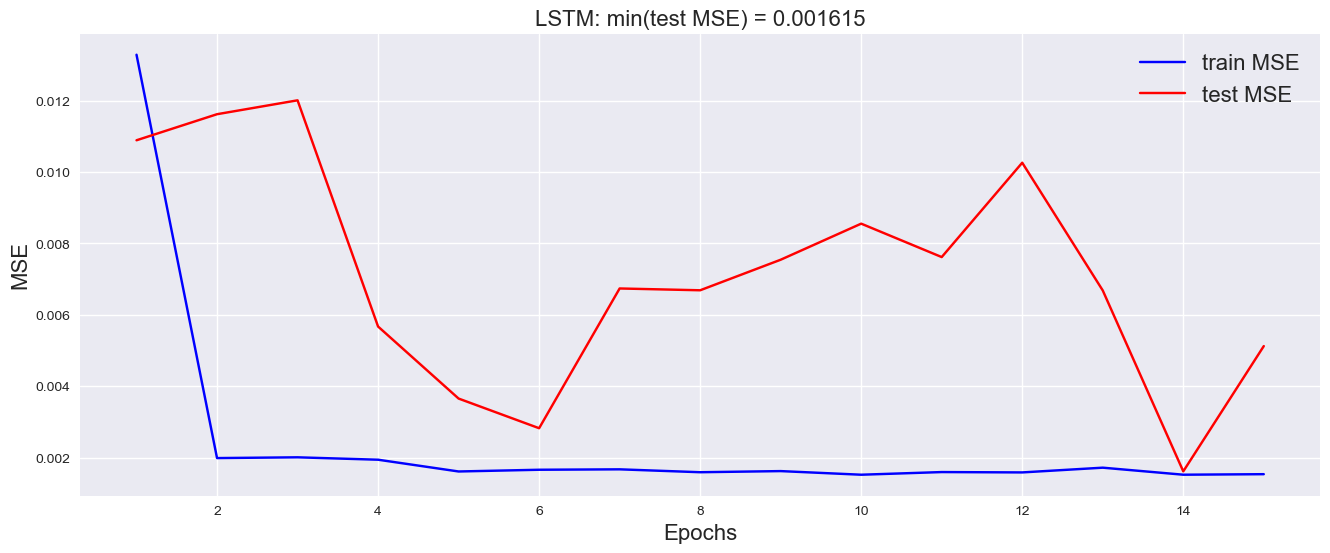

<Figure size 1600x600 with 0 Axes>

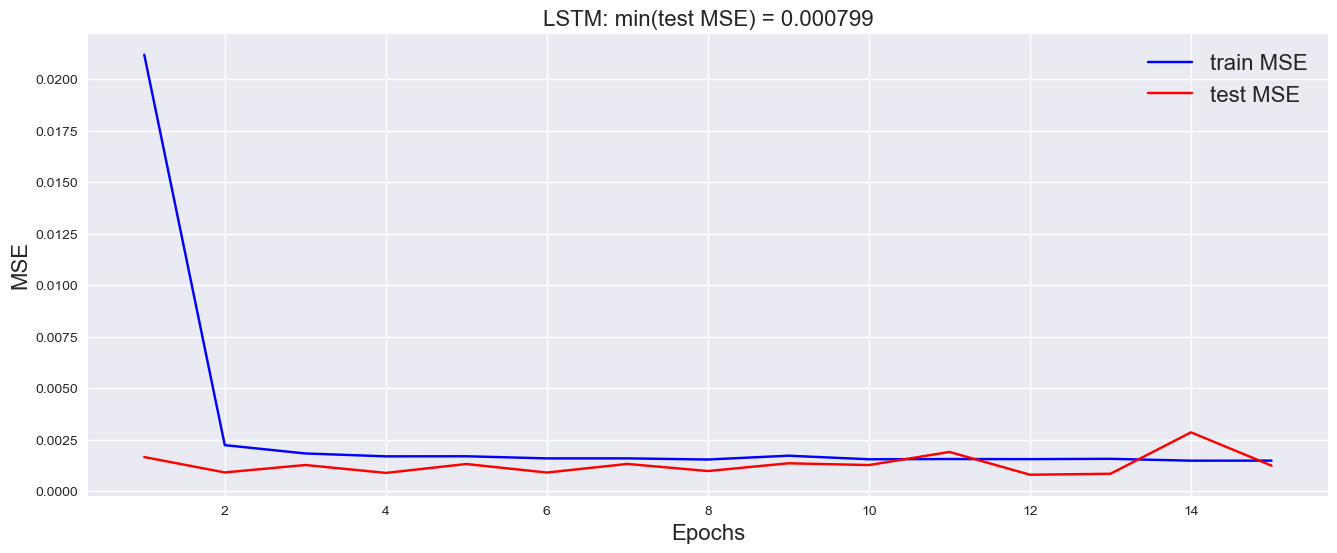

<Figure size 1600x600 with 0 Axes>

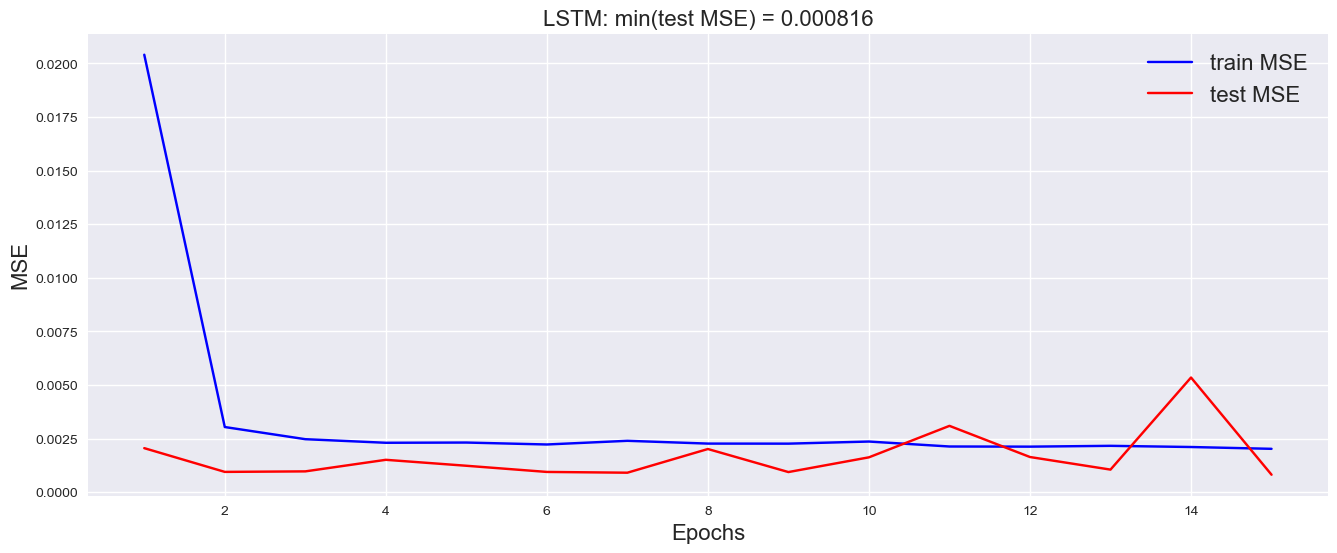

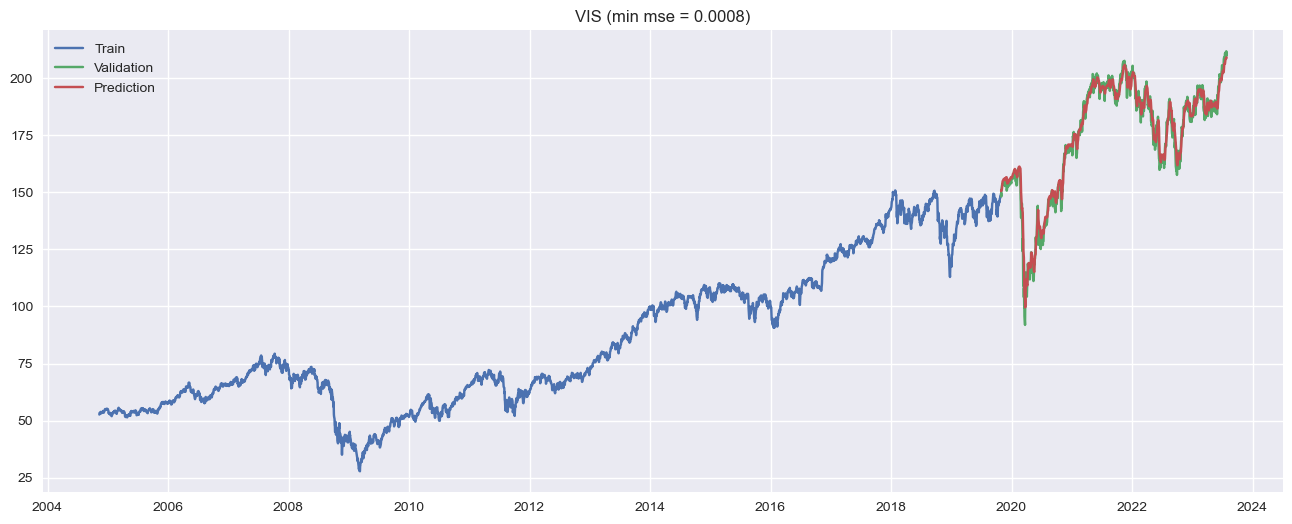

In [4]:
# load the stock price data
paths = [
    "/Users/alan/Desktop/DL/FinalProject/stocks/AAPL.csv",
    "/Users/alan/Desktop/DL/FinalProject/stocks/MSFT.csv",
    "/Users/alan/Desktop/DL/FinalProject/stocks/AMZN.csv",
    "/Users/alan/Desktop/DL/FinalProject/stocks/TSLA.csv",
    "/Users/alan/Desktop/DL/FinalProject/stocks/PEP.csv",
    "/Users/alan/Desktop/DL/FinalProject/stocks/SBUX.csv",
    "/Users/alan/Desktop/DL/FinalProject/stocks/KHC.csv",
    "/Users/alan/Desktop/DL/FinalProject/stocks/SYY.csv",
    "/Users/alan/Desktop/DL/FinalProject/etfs/QQQ.csv",
    "/Users/alan/Desktop/DL/FinalProject/etfs/XLK.csv",
    "/Users/alan/Desktop/DL/FinalProject/etfs/FDN.csv",
    "/Users/alan/Desktop/DL/FinalProject/etfs/ARKK.csv",
    "/Users/alan/Desktop/DL/FinalProject/etfs/XLP.csv",
    "/Users/alan/Desktop/DL/FinalProject/etfs/VCR.csv",
    "/Users/alan/Desktop/DL/FinalProject/etfs/VPU.csv",
    "/Users/alan/Desktop/DL/FinalProject/etfs/VIS.csv"
]

for path in paths:
    price_daily = pd.read_csv(path,parse_dates=["Date"],index_col="Date")
    regex = r".*/(.*).csv"
    company = re.findall(regex, path)[0]
    
    # prepare the tensor needed for the LSTM training process
    n_timesteps = 30

    features_set = []
    labels = []
    for i in range(n_timesteps, price_daily.shape[0]):
        features_set.append(price_daily.iloc[(i-n_timesteps):i,:])
        labels.append(price_daily.iloc[i,3])
        
    features_set, labels = np.array(features_set), np.array(labels)

    # split the train & test dataset
    n = features_set.shape[0]
    n_train = int(n * 0.80)
    n_test = n - n_train
    #print("n_train = ",str(n_train))
    #print("n_test = ",str(n_test))

    features_set_train, features_set_test =  features_set[0:n_train,:,:], features_set[n_train:n,:,:]
    labels_train, labels_test =  labels[0:n_train], labels[n_train:n]

    # data preprocessing and do the scaling
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Reshape to 2D
    features_set_train_2D = features_set_train.reshape(-1, features_set_train.shape[-1])
    features_set_test_2D = features_set_test.reshape(-1, features_set_test.shape[-1])

    # Reshape labels to be 2D
    labels_train_2D = labels_train.reshape(-1, 1)
    labels_test_2D = labels_test.reshape(-1, 1)

    # Fit the two scalers
    scaler_X.fit(features_set_train_2D)
    scaler_y.fit(labels_train_2D)

    # Do the transformation
    features_set_train_scaled_2D = scaler_X.transform(features_set_train_2D)
    features_set_test_scaled_2D = scaler_X.transform(features_set_test_2D)

    features_set_train_scaled = features_set_train_scaled_2D.reshape(features_set_train.shape)
    features_set_test_scaled = features_set_test_scaled_2D.reshape(features_set_test.shape)

    # Transform the labels and reshape them back
    labels_train_scaled_2D = scaler_y.transform(labels_train_2D)
    labels_test_scaled_2D = scaler_y.transform(labels_test_2D)

    labels_train_scaled = labels_train_scaled_2D.reshape(-1)
    labels_test_scaled = labels_test_scaled_2D.reshape(-1)

    # Set the model
    n_features = 6

    model_lstm = models.Sequential()
    model_lstm.add(LSTM(512, return_sequences=False, activation='tanh', input_shape=(n_timesteps,n_features)))
    model_lstm.add(layers.Dense(100, activation='linear')) 
    model_lstm.add(Dropout(0.4))
    model_lstm.add(layers.Dense(1, activation='relu')) 

    # train the model
    nepochs = 15
    model_lstm.compile(optimizer='adam',
                loss='mse')
    history = model_lstm.fit(features_set_train_scaled, labels_train_scaled,
            epochs=nepochs,
            batch_size=128,
            validation_data=(features_set_test_scaled, labels_test_scaled))

    # do the plots
    plt.clf()   # clear figure
    history_lstm = history.history
    train_mse = history_lstm['loss']
    test_mse = history_lstm['val_loss']
    min_test_mse = min(test_mse)

    plt.figure(figsize=(16,6))
    plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
    plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")

    #plt.ylim((0, 0.0001))
    plt.title('LSTM: min(test MSE) = ' + str(round(min(test_mse),6)),fontsize=16)
    plt.xlabel('Epochs',fontsize=16)
    plt.ylabel('MSE',fontsize=16)
    plt.legend(loc = 'upper right',fontsize=16)
    # plt.ylim(0,0.0015)

    # do the plot of the prediction
    train = price_daily.iloc[30:(30+len(labels_train)),:]
    y_hat_train = model_lstm.predict(features_set_train_scaled)
    y_hat_train = scaler_y.inverse_transform(y_hat_train)
    train["prediction"] = y_hat_train

    valid = price_daily.iloc[(30+len(labels_train)):,:]
    y_hat_valid = model_lstm.predict(features_set_test_scaled)
    y_hat_valid = scaler_y.inverse_transform(y_hat_valid)
    valid["prediction"] = y_hat_valid
    plt.style.use('seaborn')
    plt.figure(figsize=(16,6))
    plt.plot(train["Close"],label = "Train")
    plt.plot(valid[["Close","prediction"]],label = ["Validation","Prediction"])
    plt.title("{} (min mse = {:.4f})".format(company,min_test_mse))
    plt.legend()
    plt.savefig("{}.png".format(company))